In [1]:
spark

In [3]:
# from pyspark import SparkContext
# sc = SparkContext.getOrCreate()

In [2]:
import numpy as np
TOTAL = 10000
dots = sc.parallelize([2.0 * np.random.random(2) - 1.0 for i in range(TOTAL)]).cache()
print("Number of random points:", dots.count())
stats = dots.stats()
print('Mean:', stats.mean())
print('stdev:', stats.stdev())

Number of random points: 10000
Mean: [-0.00994788 -0.00117809]
stdev: [0.57954463 0.57571538]


In [3]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [4]:
# sc.stop()

## Spark

In [2]:
import os

def get_data_path(path):
    return os.path.join("../../book/", path)

In [2]:
# from pyspark.sql import SparkSession

# spark = SparkSession.builder.appName("SimpleApp").getOrCreate()

In [3]:
myRange = spark.range(1000).toDF("number")

In [4]:
divisBy2 = myRange.where("number % 2 = 0")

In [5]:
divisBy2.show(5)

+------+
|number|
+------+
|     0|
|     2|
|     4|
|     6|
|     8|
+------+
only showing top 5 rows



In [6]:
flightData2015 = spark\
  .read\
  .option("inferSchema", "true")\
  .option("header", "true")\
  .csv(get_data_path("data/flight-data/csv/2015-summary.csv"))

In [7]:
flightData2015.show(5)

+-----------------+-------------------+-----+
|DEST_COUNTRY_NAME|ORIGIN_COUNTRY_NAME|count|
+-----------------+-------------------+-----+
|    United States|            Romania|   15|
|    United States|            Croatia|    1|
|    United States|            Ireland|  344|
|            Egypt|      United States|   15|
|    United States|              India|   62|
+-----------------+-------------------+-----+
only showing top 5 rows



In [7]:
flightData2015.sort('count').explain()

== Physical Plan ==
*(1) Sort [count#27 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(count#27 ASC NULLS FIRST, 200), ENSURE_REQUIREMENTS, [id=#42]
   +- FileScan csv [DEST_COUNTRY_NAME#25,ORIGIN_COUNTRY_NAME#26,count#27] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Users/user/Study/spark-study/book/data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




In [8]:
spark.conf.set("spark.sql.shuffle.partitions", "5")

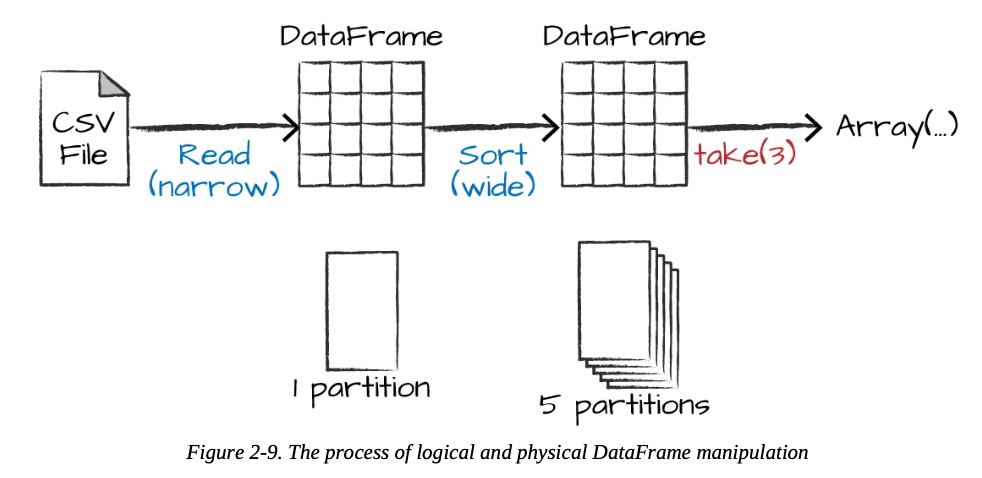

In [9]:
flightData2015.sort('count').explain()

== Physical Plan ==
*(1) Sort [count#27 ASC NULLS FIRST], true, 0
+- Exchange rangepartitioning(count#27 ASC NULLS FIRST, 5), ENSURE_REQUIREMENTS, [id=#54]
   +- FileScan csv [DEST_COUNTRY_NAME#25,ORIGIN_COUNTRY_NAME#26,count#27] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Users/user/Study/spark-study/book/data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,ORIGIN_COUNTRY_NAME:string,count:int>




In [11]:
flightData2015.sort('count').take(2)

[Row(DEST_COUNTRY_NAME='United States', ORIGIN_COUNTRY_NAME='Singapore', count=1),
 Row(DEST_COUNTRY_NAME='Moldova', ORIGIN_COUNTRY_NAME='United States', count=1)]

## Spark SQL

In [10]:
tableName = "flight_data_2015"
flightData2015.createOrReplaceTempView(tableName)

In [11]:
sqlWay = spark.sql(f"""
SELECT DEST_COUNTRY_NAME, count(1)
FROM {tableName}
GROUP BY DEST_COUNTRY_NAME
""")

dataFrameWay = flightData2015\
  .groupBy("DEST_COUNTRY_NAME")\
  .count()

In [12]:
sqlWay.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#25], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#25, 5), ENSURE_REQUIREMENTS, [id=#77]
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#25], functions=[partial_count(1)])
      +- FileScan csv [DEST_COUNTRY_NAME#25] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Users/user/Study/spark-study/book/data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [13]:
dataFrameWay.explain()

== Physical Plan ==
*(2) HashAggregate(keys=[DEST_COUNTRY_NAME#25], functions=[count(1)])
+- Exchange hashpartitioning(DEST_COUNTRY_NAME#25, 5), ENSURE_REQUIREMENTS, [id=#96]
   +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#25], functions=[partial_count(1)])
      +- FileScan csv [DEST_COUNTRY_NAME#25] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Users/user/Study/spark-study/book/data/flight-data/csv/2015-summary.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string>




In [16]:
from pyspark.sql.functions import max

flightData2015.select(max("count")).take(1)

[Row(max(count)=370002)]

In [17]:
maxSql = spark.sql("""
SELECT DEST_COUNTRY_NAME, sum(count) as destination_total
FROM flight_data_2015
GROUP BY DEST_COUNTRY_NAME
ORDER BY sum(count) DESC
LIMIT 5
""")

maxSql.show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



In [18]:
from pyspark.sql.functions import desc

flightData2015\
  .groupBy("DEST_COUNTRY_NAME")\
  .sum("count")\
  .withColumnRenamed("sum(count)", "destination_total")\
  .sort(desc("destination_total"))\
  .limit(5)\
  .show()

+-----------------+-----------------+
|DEST_COUNTRY_NAME|destination_total|
+-----------------+-----------------+
|    United States|           411352|
|           Canada|             8399|
|           Mexico|             7140|
|   United Kingdom|             2025|
|            Japan|             1548|
+-----------------+-----------------+



In [19]:
flightData2015\
  .groupBy("DEST_COUNTRY_NAME")\
  .sum("count")\
  .withColumnRenamed("sum(count)", "destination_total")\
  .sort(desc("destination_total"))\
  .limit(5)\
  .explain()

== Physical Plan ==
TakeOrderedAndProject(limit=5, orderBy=[destination_total#120L DESC NULLS LAST], output=[DEST_COUNTRY_NAME#25,destination_total#120L])
+- *(2) HashAggregate(keys=[DEST_COUNTRY_NAME#25], functions=[sum(cast(count#27 as bigint))])
   +- Exchange hashpartitioning(DEST_COUNTRY_NAME#25, 5), ENSURE_REQUIREMENTS, [id=#222]
      +- *(1) HashAggregate(keys=[DEST_COUNTRY_NAME#25], functions=[partial_sum(cast(count#27 as bigint))])
         +- FileScan csv [DEST_COUNTRY_NAME#25,count#27] Batched: false, DataFilters: [], Format: CSV, Location: InMemoryFileIndex[file:/Users/user/Study/test/spark-study/book/data/flight-data/csv/2015-summary...., PartitionFilters: [], PushedFilters: [], ReadSchema: struct<DEST_COUNTRY_NAME:string,count:int>




## Structed Streaming

In [3]:
from pyspark.sql import SparkSession

# spark = SparkSession.builder.appName("SimpleApp").getOrCreate()

staticDataFrame = spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load(get_data_path("data/retail-data/by-day/*.csv"))

In [3]:
staticDataFrame.createOrReplaceTempView("retail_data")

In [4]:
staticSchema = staticDataFrame.schema

In [5]:
staticDataFrame.show(5)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdom|
|   580538|    21914|BLUE HARMONICA IN...|      24|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|
|   580538|    22467|   GUMBALL COAT RACK|       6|2011-12-05 08:38:00|     2.55|   14075.0|United Kingdom|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
only showing top 5 rows



In [6]:
from pyspark.sql.functions import window, column, desc, col

staticDataFrame\
  .selectExpr(
    "CustomerId",
    "(UnitPrice * Quantity) as total_cost",
    "InvoiceDate")\
  .groupBy(
    col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
  .sum("total_cost")\
  .sort(desc("sum(total_cost)"))\
  .show(5)

+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   17450.0|{2011-09-20 09:00...|          71601.44|
|      null|{2011-11-14 09:00...|          55316.08|
|      null|{2011-11-07 09:00...|          42939.17|
|      null|{2011-03-29 09:00...| 33521.39999999998|
|      null|{2011-12-08 09:00...|31975.590000000007|
+----------+--------------------+------------------+
only showing top 5 rows



In [7]:
streamingDataFrame = spark.readStream\
    .schema(staticSchema)\
    .option("maxFilesPerTrigger", 1)\
    .format("csv")\
    .option("header", "true")\
    .load(get_data_path("data/retail-data/by-day/*.csv"))

In [8]:
streamingDataFrame.isStreaming

True

In [8]:
purchaseByCustomerPerHour = streamingDataFrame\
  .selectExpr(
    "CustomerId",
    "(UnitPrice * Quantity) as total_cost",
    "InvoiceDate")\
  .groupBy(
    col("CustomerId"), window(col("InvoiceDate"), "1 day"))\
  .sum("total_cost")

In [9]:
# spark.conf.set("spark.sql.streaming.forceDeleteTempCheckpointLocation", "true")

In [13]:
streamQuery = purchaseByCustomerPerHour.writeStream\
    .format("console") \
    .option("checkpointLocation", "./tmp/checkpoint")\
    .outputMode("complete")\
    .start()

-------------------------------------------
Batch: 0
-------------------------------------------
+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   17460.0|{2010-12-01 09:00...|              19.9|
|   13408.0|{2010-12-01 09:00...|1024.6800000000003|
|   15235.0|{2010-12-01 09:00...|              79.5|
|   17905.0|{2010-12-01 09:00...|201.74999999999997|
|   14045.0|{2010-12-01 09:00...|             326.4|
|   14594.0|{2010-12-01 09:00...|254.99999999999997|
|   16098.0|{2010-12-01 09:00...|430.59999999999997|
|   16552.0|{2010-12-01 09:00...|             95.29|
|   16274.0|{2010-12-01 09:00...|357.94999999999993|
|   13468.0|{2010-12-01 09:00...|360.05000000000007|
|   18074.0|{2010-12-01 09:00...|             489.6|
|   12662.0|{2010-12-01 09:00...|            261.48|
|   16955.0|{2010-12-01 09:00...|156.09999999999997|
|   13694.0|{2010-12-01 09:00...|            842.12|
| 

-------------------------------------------
Batch: 1
-------------------------------------------
+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   17460.0|{2010-12-01 09:00...|              19.9|
|   13408.0|{2010-12-01 09:00...|1024.6800000000003|
|   15235.0|{2010-12-01 09:00...|              79.5|
|   13295.0|{2010-12-02 09:00...|             -3.25|
|   14156.0|{2010-12-02 09:00...|              -7.5|
|   18239.0|{2010-12-02 09:00...| 438.0999999999999|
|   17905.0|{2010-12-01 09:00...|201.74999999999997|
|   16752.0|{2010-12-02 09:00...|             207.5|
|   13715.0|{2010-12-01 09:00...| 272.6499999999999|
|   14045.0|{2010-12-01 09:00...|             326.4|
|   18041.0|{2010-12-02 09:00...| 428.9399999999999|
|   14395.0|{2010-12-02 09:00...|            308.68|
|   14594.0|{2010-12-01 09:00...|254.99999999999997|
|   14060.0|{2010-12-02 09:00...|            339.84|
| 

-------------------------------------------
Batch: 2
-------------------------------------------
+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   17460.0|{2010-12-01 09:00...|              19.9|
|   13408.0|{2010-12-01 09:00...|1024.6800000000003|
|   15235.0|{2010-12-01 09:00...|              79.5|
|   13295.0|{2010-12-02 09:00...|             -3.25|
|   12779.0|{2010-12-03 09:00...|            248.16|
|   12841.0|{2010-12-03 09:00...|            294.25|
|   14156.0|{2010-12-02 09:00...|              -7.5|
|   13520.0|{2010-12-03 09:00...|             303.4|
|   18239.0|{2010-12-02 09:00...| 438.0999999999999|
|   12712.0|{2010-12-03 09:00...|175.53000000000003|
|   17905.0|{2010-12-01 09:00...|201.74999999999997|
|   16752.0|{2010-12-02 09:00...|             207.5|
|   16883.0|{2010-12-03 09:00...|            128.03|
|   16725.0|{2010-12-03 09:00...|122.15000000000002|
| 

-------------------------------------------
Batch: 3
-------------------------------------------
+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   13269.0|{2010-12-05 09:00...|            351.43|
|   12647.0|{2010-12-05 09:00...|             372.0|
|   17460.0|{2010-12-01 09:00...|              19.9|
|   13408.0|{2010-12-01 09:00...|1024.6800000000003|
|   15235.0|{2010-12-01 09:00...|              79.5|
|   14506.0|{2010-12-05 09:00...|269.69999999999993|
|   12841.0|{2010-12-03 09:00...|            294.25|
|   13295.0|{2010-12-02 09:00...|             -3.25|
|   12779.0|{2010-12-03 09:00...|            248.16|
|   14813.0|{2010-12-05 09:00...|155.42999999999998|
|   14527.0|{2010-12-05 09:00...| 263.6599999999999|
|   14156.0|{2010-12-02 09:00...|              -7.5|
|   13520.0|{2010-12-03 09:00...|             303.4|
|   18239.0|{2010-12-02 09:00...| 438.0999999999999|
| 

-------------------------------------------
Batch: 4
-------------------------------------------
+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   13269.0|{2010-12-05 09:00...|            351.43|
|   12647.0|{2010-12-05 09:00...|             372.0|
|   17460.0|{2010-12-01 09:00...|              19.9|
|   13408.0|{2010-12-01 09:00...|1024.6800000000003|
|   15235.0|{2010-12-01 09:00...|              79.5|
|   13495.0|{2010-12-06 09:00...|510.94999999999993|
|   14506.0|{2010-12-05 09:00...|269.69999999999993|
|   14911.0|{2010-12-06 09:00...|1182.5000000000002|
|   12841.0|{2010-12-03 09:00...|            294.25|
|   13295.0|{2010-12-02 09:00...|             -3.25|
|   12779.0|{2010-12-03 09:00...|            248.16|
|   14085.0|{2010-12-06 09:00...|            308.05|
|   14527.0|{2010-12-05 09:00...| 263.6599999999999|
|   14813.0|{2010-12-05 09:00...|155.42999999999998|
| 

-------------------------------------------
Batch: 5
-------------------------------------------
+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   13269.0|{2010-12-05 09:00...|            351.43|
|   12647.0|{2010-12-05 09:00...|             372.0|
|   17460.0|{2010-12-01 09:00...|              19.9|
|   16950.0|{2010-12-07 09:00...|             172.0|
|   13408.0|{2010-12-01 09:00...|1024.6800000000003|
|   15235.0|{2010-12-01 09:00...|              79.5|
|   13495.0|{2010-12-06 09:00...|510.94999999999993|
|   14506.0|{2010-12-05 09:00...|269.69999999999993|
|   14911.0|{2010-12-06 09:00...|1182.5000000000002|
|   12841.0|{2010-12-03 09:00...|            294.25|
|   13295.0|{2010-12-02 09:00...|             -3.25|
|   12779.0|{2010-12-03 09:00...|            248.16|
|   14085.0|{2010-12-06 09:00...|            308.05|
|   14813.0|{2010-12-05 09:00...|155.42999999999998|
| 

-------------------------------------------
Batch: 6
-------------------------------------------
+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   13269.0|{2010-12-05 09:00...|            351.43|
|   12647.0|{2010-12-05 09:00...|             372.0|
|   17460.0|{2010-12-01 09:00...|              19.9|
|   16950.0|{2010-12-07 09:00...|             172.0|
|   17262.0|{2010-12-08 09:00...|            268.86|
|   13408.0|{2010-12-01 09:00...|1024.6800000000003|
|   13758.0|{2010-12-08 09:00...|             356.4|
|   17894.0|{2010-12-08 09:00...|            106.77|
|   15235.0|{2010-12-01 09:00...|              79.5|
|   13495.0|{2010-12-06 09:00...|510.94999999999993|
|   14506.0|{2010-12-05 09:00...|269.69999999999993|
|   14911.0|{2010-12-06 09:00...|1182.5000000000002|
|   14796.0|{2010-12-08 09:00...| 669.2600000000001|
|   12841.0|{2010-12-03 09:00...|            294.25|
| 

-------------------------------------------
Batch: 7
-------------------------------------------
+----------+--------------------+-------------------+
|CustomerId|              window|    sum(total_cost)|
+----------+--------------------+-------------------+
|   13269.0|{2010-12-05 09:00...|             351.43|
|   16950.0|{2010-12-07 09:00...|              172.0|
|   12647.0|{2010-12-05 09:00...|              372.0|
|   17460.0|{2010-12-01 09:00...|               19.9|
|   17262.0|{2010-12-08 09:00...|             268.86|
|   13408.0|{2010-12-01 09:00...| 1024.6800000000003|
|   17894.0|{2010-12-08 09:00...|             106.77|
|   15235.0|{2010-12-01 09:00...|               79.5|
|   13758.0|{2010-12-08 09:00...|              356.4|
|   13495.0|{2010-12-06 09:00...| 510.94999999999993|
|   12649.0|{2010-12-09 09:00...|-19.799999999999997|
|   17526.0|{2010-12-09 09:00...| 226.79999999999998|
|   14506.0|{2010-12-05 09:00...| 269.69999999999993|
|   14911.0|{2010-12-06 09:00...| 1182.

-------------------------------------------
Batch: 8
-------------------------------------------
+----------+--------------------+-------------------+
|CustomerId|              window|    sum(total_cost)|
+----------+--------------------+-------------------+
|   13269.0|{2010-12-05 09:00...|             351.43|
|   16950.0|{2010-12-07 09:00...|              172.0|
|   12647.0|{2010-12-05 09:00...|              372.0|
|   17460.0|{2010-12-01 09:00...|               19.9|
|   17262.0|{2010-12-08 09:00...|             268.86|
|   13408.0|{2010-12-01 09:00...| 1024.6800000000003|
|   17894.0|{2010-12-08 09:00...|             106.77|
|   15235.0|{2010-12-01 09:00...|               79.5|
|   13758.0|{2010-12-08 09:00...|              356.4|
|   12649.0|{2010-12-09 09:00...|-19.799999999999997|
|   14506.0|{2010-12-05 09:00...| 269.69999999999993|
|   13495.0|{2010-12-06 09:00...| 510.94999999999993|
|   17526.0|{2010-12-09 09:00...| 226.79999999999998|
|   14911.0|{2010-12-06 09:00...| 1182.

-------------------------------------------
Batch: 9
-------------------------------------------
+----------+--------------------+-------------------+
|CustomerId|              window|    sum(total_cost)|
+----------+--------------------+-------------------+
|   13269.0|{2010-12-05 09:00...|             351.43|
|   16950.0|{2010-12-07 09:00...|              172.0|
|   12647.0|{2010-12-05 09:00...|              372.0|
|   17460.0|{2010-12-01 09:00...|               19.9|
|   17262.0|{2010-12-08 09:00...|             268.86|
|   13408.0|{2010-12-01 09:00...| 1024.6800000000003|
|   17894.0|{2010-12-08 09:00...|             106.77|
|   15235.0|{2010-12-01 09:00...|               79.5|
|   13758.0|{2010-12-08 09:00...|              356.4|
|   12649.0|{2010-12-09 09:00...|-19.799999999999997|
|   14506.0|{2010-12-05 09:00...| 269.69999999999993|
|   13495.0|{2010-12-06 09:00...| 510.94999999999993|
|   17526.0|{2010-12-09 09:00...| 226.79999999999998|
|   14911.0|{2010-12-06 09:00...| 1182.

-------------------------------------------
Batch: 10
-------------------------------------------
+----------+--------------------+-------------------+
|CustomerId|              window|    sum(total_cost)|
+----------+--------------------+-------------------+
|   13269.0|{2010-12-05 09:00...|             351.43|
|   16950.0|{2010-12-07 09:00...|              172.0|
|   17790.0|{2010-12-13 09:00...|              154.8|
|   12647.0|{2010-12-05 09:00...|              372.0|
|   17460.0|{2010-12-01 09:00...|               19.9|
|   17262.0|{2010-12-08 09:00...|             268.86|
|   13408.0|{2010-12-01 09:00...| 1024.6800000000003|
|   17894.0|{2010-12-08 09:00...|             106.77|
|   15235.0|{2010-12-01 09:00...|               79.5|
|   13758.0|{2010-12-08 09:00...|              356.4|
|   12649.0|{2010-12-09 09:00...|-19.799999999999997|
|   14506.0|{2010-12-05 09:00...| 269.69999999999993|
|   13495.0|{2010-12-06 09:00...| 510.94999999999993|
|   17231.0|{2010-12-13 09:00...| 216.

-------------------------------------------
Batch: 11
-------------------------------------------
+----------+--------------------+-------------------+
|CustomerId|              window|    sum(total_cost)|
+----------+--------------------+-------------------+
|   13269.0|{2010-12-05 09:00...|             351.43|
|   16950.0|{2010-12-07 09:00...|              172.0|
|   13050.0|{2010-12-14 09:00...|             292.42|
|   17790.0|{2010-12-13 09:00...|              154.8|
|   12647.0|{2010-12-05 09:00...|              372.0|
|   17460.0|{2010-12-01 09:00...|               19.9|
|   17262.0|{2010-12-08 09:00...|             268.86|
|   13408.0|{2010-12-01 09:00...| 1024.6800000000003|
|   17894.0|{2010-12-08 09:00...|             106.77|
|   15235.0|{2010-12-01 09:00...|               79.5|
|   13758.0|{2010-12-08 09:00...|              356.4|
|   12649.0|{2010-12-09 09:00...|-19.799999999999997|
|   14506.0|{2010-12-05 09:00...| 269.69999999999993|
|   13495.0|{2010-12-06 09:00...| 510.

-------------------------------------------
Batch: 12
-------------------------------------------
+----------+--------------------+-------------------+
|CustomerId|              window|    sum(total_cost)|
+----------+--------------------+-------------------+
|   13269.0|{2010-12-05 09:00...|             351.43|
|   16950.0|{2010-12-07 09:00...|              172.0|
|   13050.0|{2010-12-14 09:00...|             292.42|
|   17790.0|{2010-12-13 09:00...|              154.8|
|   12647.0|{2010-12-05 09:00...|              372.0|
|   17460.0|{2010-12-01 09:00...|               19.9|
|   17262.0|{2010-12-08 09:00...|             268.86|
|   13408.0|{2010-12-01 09:00...| 1024.6800000000003|
|   17894.0|{2010-12-08 09:00...|             106.77|
|   13092.0|{2010-12-15 09:00...|             185.45|
|   15235.0|{2010-12-01 09:00...|               79.5|
|   13758.0|{2010-12-08 09:00...|              356.4|
|   12649.0|{2010-12-09 09:00...|-19.799999999999997|
|   14506.0|{2010-12-05 09:00...| 269.

-------------------------------------------
Batch: 13
-------------------------------------------
+----------+--------------------+-------------------+
|CustomerId|              window|    sum(total_cost)|
+----------+--------------------+-------------------+
|   13269.0|{2010-12-05 09:00...|             351.43|
|   16950.0|{2010-12-07 09:00...|              172.0|
|   13050.0|{2010-12-14 09:00...|             292.42|
|   17790.0|{2010-12-13 09:00...|              154.8|
|   12647.0|{2010-12-05 09:00...|              372.0|
|   17460.0|{2010-12-01 09:00...|               19.9|
|   17262.0|{2010-12-08 09:00...|             268.86|
|   13408.0|{2010-12-01 09:00...| 1024.6800000000003|
|   13534.0|{2010-12-16 09:00...| 283.20000000000005|
|   17894.0|{2010-12-08 09:00...|             106.77|
|   13092.0|{2010-12-15 09:00...|             185.45|
|   15235.0|{2010-12-01 09:00...|               79.5|
|   13758.0|{2010-12-08 09:00...|              356.4|
|   12649.0|{2010-12-09 09:00...|-19.7

-------------------------------------------
Batch: 14
-------------------------------------------
+----------+--------------------+-------------------+
|CustomerId|              window|    sum(total_cost)|
+----------+--------------------+-------------------+
|   13269.0|{2010-12-05 09:00...|             351.43|
|   16950.0|{2010-12-07 09:00...|              172.0|
|   13050.0|{2010-12-14 09:00...|             292.42|
|   17790.0|{2010-12-13 09:00...|              154.8|
|   12647.0|{2010-12-05 09:00...|              372.0|
|   17460.0|{2010-12-01 09:00...|               19.9|
|   17262.0|{2010-12-08 09:00...|             268.86|
|   13408.0|{2010-12-01 09:00...| 1024.6800000000003|
|   13534.0|{2010-12-16 09:00...| 283.20000000000005|
|   17894.0|{2010-12-08 09:00...|             106.77|
|   13092.0|{2010-12-15 09:00...|             185.45|
|   15235.0|{2010-12-01 09:00...|               79.5|
|   13758.0|{2010-12-08 09:00...|              356.4|
|   12649.0|{2010-12-09 09:00...|-19.7

In [14]:
streamQuery.stop()

21/12/29 00:15:32 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@c020411 is aborting.
21/12/29 00:15:32 ERROR WriteToDataSourceV2Exec: Data source write support org.apache.spark.sql.execution.streaming.sources.MicroBatchWrite@c020411 aborted.
21/12/29 00:15:32 WARN Shell: Interrupted while joining on: Thread[Thread-24816,5,]
java.lang.InterruptedException
	at java.base/java.lang.Object.wait(Native Method)
	at java.base/java.lang.Thread.join(Thread.java:1300)
	at java.base/java.lang.Thread.join(Thread.java:1375)
	at org.apache.hadoop.util.Shell.joinThread(Shell.java:1043)
	at org.apache.hadoop.util.Shell.runCommand(Shell.java:1003)
	at org.apache.hadoop.util.Shell.run(Shell.java:901)
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:1213)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1307)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1289)
	at org.apache.hadoop.fs.RawLo

21/12/29 00:15:34 WARN Shell: Interrupted while joining on: Thread[Thread-24813,5,]
java.lang.InterruptedException
	at java.base/java.lang.Object.wait(Native Method)
	at java.base/java.lang.Thread.join(Thread.java:1300)
	at java.base/java.lang.Thread.join(Thread.java:1375)
	at org.apache.hadoop.util.Shell.joinThread(Shell.java:1043)
	at org.apache.hadoop.util.Shell.runCommand(Shell.java:1003)
	at org.apache.hadoop.util.Shell.run(Shell.java:901)
	at org.apache.hadoop.util.Shell$ShellCommandExecutor.execute(Shell.java:1213)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1307)
	at org.apache.hadoop.util.Shell.execCommand(Shell.java:1289)
	at org.apache.hadoop.fs.FileUtil.readLink(FileUtil.java:208)
	at org.apache.hadoop.fs.RawLocalFileSystem.deprecatedGetFileLinkStatusInternal(RawLocalFileSystem.java:1000)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatusInternal(RawLocalFileSystem.java:989)
	at org.apache.hadoop.fs.RawLocalFileSystem.getFileLinkStatus(RawLocalFileSys

In [ ]:
streamQuery = purchaseByCustomerPerHour.writeStream\
    .format("memory")\
    .queryName("custaomer_purchases")\
    .outputMode("complete")\
    .start()

In [66]:
spark.sql("""
  SELECT *
  FROM customer_purchases2
  ORDER BY `sum(total_cost)` DESC
  """)\
  .show(5)

+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|      null|{2011-03-29 09:00...| 33521.39999999998|
|      null|{2010-12-21 09:00...|31347.479999999938|
|   18102.0|{2010-12-07 09:00...|          25920.37|
|      null|{2010-12-10 09:00...|25399.560000000012|
|      null|{2010-12-17 09:00...|25371.769999999768|
+----------+--------------------+------------------+
only showing top 5 rows



In [87]:
spark.sql("""
  SELECT *
  FROM customer_purchases2
  ORDER BY `sum(total_cost)` DESC
  """)\
  .show(5)

+----------+--------------------+------------------+
|CustomerId|              window|   sum(total_cost)|
+----------+--------------------+------------------+
|   17450.0|{2011-09-20 09:00...|          71601.44|
|      null|{2011-03-29 09:00...| 33521.39999999998|
|   18102.0|{2011-09-15 09:00...|31661.540000000005|
|      null|{2010-12-21 09:00...|31347.479999999938|
|   18102.0|{2010-12-07 09:00...|          25920.37|
+----------+--------------------+------------------+
only showing top 5 rows



![image](https://user-images.githubusercontent.com/18041103/147495637-12b7c1c5-1b42-464b-a3bd-4e9b43a3ba63.png)


## Spark ML

In [15]:
# spark = SparkSession.builder.appName("SimpleApp").getOrCreate()

In [94]:
from pyspark.sql.functions import date_format, col

preppedDataFrame = staticDataFrame\
  .na.fill(0)\
  .withColumn("day_of_week", date_format(col("InvoiceDate"), "EEEE"))\
  .coalesce(5)

In [95]:
trainDataFrame = preppedDataFrame\
  .where("InvoiceDate < '2011-07-01'")
testDataFrame = preppedDataFrame\
  .where("InvoiceDate >= '2011-07-01'")

In [96]:
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer()\
  .setInputCol("day_of_week")\
  .setOutputCol("day_of_week_index")


In [97]:
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder()\
  .setInputCol("day_of_week_index")\
  .setOutputCol("day_of_week_encoded")

In [98]:
from pyspark.ml.feature import VectorAssembler

vectorAssembler = VectorAssembler()\
  .setInputCols(["UnitPrice", "Quantity", "day_of_week_encoded"])\
  .setOutputCol("features")

In [99]:
from pyspark.ml import Pipeline

transformationPipeline = Pipeline()\
  .setStages([indexer, encoder, vectorAssembler])

In [100]:
fittedPipeline = transformationPipeline.fit(trainDataFrame)
transformedTraining = fittedPipeline.transform(trainDataFrame)

In [102]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans()\
  .setK(20)\
  .setSeed(1)

In [103]:
kmModel = kmeans.fit(transformedTraining)

21/12/28 02:57:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
21/12/28 02:57:38 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [104]:
transformedTest = fittedPipeline.transform(testDataFrame)

In [112]:
transformedTraining.show(3)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+-----------------+-------------------+--------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|day_of_week|day_of_week_index|day_of_week_encoded|            features|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+-----------------+-------------------+--------------------+
|   537226|    22811|SET OF 6 T-LIGHTS...|       6|2010-12-06 08:34:00|     2.95|   15987.0|United Kingdom|     Monday|              2.0|      (5,[2],[1.0])|(7,[0,1,4],[2.95,...|
|   537226|    21713|CITRONELLA CANDLE...|       8|2010-12-06 08:34:00|      2.1|   15987.0|United Kingdom|     Monday|              2.0|      (5,[2],[1.0])|(7,[0,1,4],[2.1,8...|
|   537226|    22927|GREEN GIANT GARDE...|       2|2010-12-06 08:34:00|     5.95|   15987.0|United Kingdo

In [117]:
transformedTest.show(3)

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+-----------------+-------------------+--------------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|day_of_week|day_of_week_index|day_of_week_encoded|            features|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+-----------+-----------------+-------------------+--------------------+
|   580538|    23084|  RABBIT NIGHT LIGHT|      48|2011-12-05 08:38:00|     1.79|   14075.0|United Kingdom|     Monday|              2.0|      (5,[2],[1.0])|(7,[0,1,4],[1.79,...|
|   580538|    23077| DOUGHNUT LIP GLOSS |      20|2011-12-05 08:38:00|     1.25|   14075.0|United Kingdom|     Monday|              2.0|      (5,[2],[1.0])|(7,[0,1,4],[1.25,...|
|   580538|    22906|12 MESSAGE CARDS ...|      24|2011-12-05 08:38:00|     1.65|   14075.0|United Kingdo

In [114]:
kmModel.clusterCenters()

[array([3.6340258 , 5.63459494, 0.19581065, 0.1938833 , 0.18023509,
        0.17188605, 0.149228  ]),
 array([1.0400e+00, 7.4215e+04, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00]),
 array([ 1.0400e+00, -7.4215e+04,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00]),
 array([ 3.897e+04, -1.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
         0.000e+00,  1.000e+00]),
 array([7.85972222e-01, 1.14452778e+03, 2.08333333e-01, 2.50000000e-01,
        9.72222222e-02, 2.22222222e-01, 1.66666667e-01]),
 array([ 5.43415e+03, -1.00000e+00,  0.00000e+00,  1.25000e-01,
         3.75000e-01,  0.00000e+00,  5.00000e-01]),
 array([ 1.6670865e+04, -1.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  1.0000000e+00,  0.0000000e+00]),
 array([3.8500e-01, 4.4435e+03, 2.5000e-01, 2.5000e-01, 0.0000e+00,
        0.0000e+00, 5.0000e-01]),
 array([1.11846743e+00, 5.25536398e+02, 3.10344828e-01, 1.95402299e-01,
        1.76245211e-01, 2.06896552e

In [118]:
spark.stop()